In [38]:
import nltk
import numpy as np
import json
import pickle
import timeit
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [91]:
devfile = "../A1_Data/dev.json"
trainfile = "../A1_Data/train.json"

In [52]:
f = open("stopwords_list.dat")
stopwords = [word.strip().lower() for word in f.readlines()]
f.close()

### Training Phase

In [54]:
train_data = []
train_labels = []
f = open(trainfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    train_data.append(json_dump["review"])
    train_labels.append(json_dump["ratings"])
f.close()

In [55]:
vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, stop_words=stopwords, min_df=5)

In [72]:
feature_vector = vectorizer.fit_transform(train_data)
feature_vector.shape

(1000000, 85557)


In [57]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

In [58]:
for i in range(0,len(train_data),1000):
    fv = feature_vector[i:i+1000].toarray()
    model.partial_fit(fv, train_labels[i:i+1000], classes=np.unique(train_labels))

In [73]:
pickle.dump(feature_vector,open("tfidf_train_vector.pickle", "wb"))
pickle.dump(vectorizer,open("vectorizer.pickle", "wb"))
pickle.dump(model,open("naive_bayes_model.pickle", "wb"))

### Some sanity checks

In [117]:
sanity_check = "Dishonest, untrustworthy, flaw-hiding dealership that is an embarrassment to the brand it bears"
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

1.0

In [118]:
sanity_check = "Excellent service. The staff is so friendly and always  willing to have conversations with their clients."
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

5.0

### Validation phase

In [92]:
dev_data = []
dev_labels = []
f = open(devfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    dev_data.append(json_dump["review"])
    dev_labels.append(json_dump["ratings"])
f.close()

In [93]:
dev_feature_vector = vectorizer.transform(dev_data)
dev_feature_vector.shape

(200000, 85557)


In [94]:
conf_mat = np.zeros((5,5), dtype=int)
for i in range(0,len(dev_data),1000):
    fv = dev_feature_vector[i:i+1000].toarray()
    y_pred = model.predict(fv)
    conf_mat+= confusion_matrix(y_pred, dev_labels[i:i+1000])
conf_mat

[[23013  5492  2496  1234  1680]
 [ 1111   952   255    29     9]
 [  729  1891  1708   214    47]
 [ 1952  4889 11966 19572  9475]
 [ 2984  2915  5691 22957 76739]]


In [111]:
print("Accuracy: \t",conf_mat.trace()/len(dev_data))
score = 0
for i in range(5):
    for j in range(5):
        score+=conf_mat[i][j]*((i-j)**2)
print("Cost: \t\t",score)

Accuracy: 	 0.60992
Cost: 		 238499


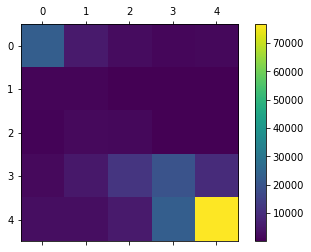

In [119]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
fig.colorbar(cax)
plt.savefig("Conf_Mat_Baseline.jpg")